# Monday
## Prepare lab meeting
- **Realtime fmri**
- What do we have so far?
- How does it work?
  - General outline of how it works
  - [our github](github.com/gallantlab/realtimefmri)
  - `collect.py`, `preprocess.py`, `stimulate.py`
  - Time profiling
- What needs work?
  - Detrending
- Get opinions
- What are some uses you are most interested in?
  - Bayesian experimental design: retinotopy

# Tuesday
Start working on semantic decoding paper

- **semantic system** meaning system in the brain
  - encode semantics: e.g. respond to words more than non words
  - in this study, good validation prediction performance in:
    - lateral and ventral *temporal cortex*
    - lat and medial *PFC*
    - lat and med *parietal cortex*
    - med, sup, and inf *prefrontal cortex*
- semantic atlas, generalized location of semantic 

### result: most areas represent information about specific *semantic domains* (groups of related concepts)
- what is a semantic domain: a group of related concepts
- e.g. "family": [mother, father, sister, brother], "tools": [handles, hammer, nail, scissor, use, wield]

## Method

In [1]:
from sklearn.decomposition import PCA

In [2]:
pca = PCA()

In [ ]:
pca.fit(np.random.randn())

1. **voxel-wise modeling (VM)**: estimate semantic selectivity for each voxel
  - *stimulus features*: features extracted from stimuli
  - in this study: *word embedding space*, normalized co-occurrence between each word and a set of 985 common English words (e.g. above, worry, mother)
  - regression determines how each feature modulates BOLD responses in each voxel

  - *nuisance regressors*: account for responses caused by low-level stimulus properties (e.g. word rate, phonemic content)

  - **VM** enables model to be validated on unseen data. Allows computation of *effect size* by finding fraction of variance explained by the models (*explained variance*).

  - Y (n_vox x n_timepts) = B (n_vox x n_features) \* X (n_features x n_timepts)
  
  - "By inspecting the fit models we can determine which specific semantic domains are represented in each voxel"
  - that means, for each voxel, we can say which of the word embedding space dimensions it encodes
  - *n_features*: 985 (english 1000 features)
  - *B*: weights (n_vox x n_features)

3. applying principal components analysis to estimated models *aggregated across subjects* (how do you aggregate? append *B*s [B0, B1, B2, ..., Bn] (n_vox\*n_subj x n_features)
  - B_pc (n_vox x n_pcs)

4. decide which ones are shared semantic dimensions (vs. noise, indiv differences)
  - Y (n_vox x n_timepts) = B(n_vox x 1) \* X (1 x n_timepts)
  - for each pc
  - compute explained variance for each of the pcs
  - is ev for these > chance (how well do stimulus matrix pcs explain variance?)
  - what is this statistic?
    - can you predict the responses from just the stimulus alone
    - "if there is no structured semantic space underlying the true model weights (i.e. the weights for each voxel are independent from other voxels) then the PCs of the estimated models weights will be identical to the PCs of the stimulus matrix."
  - ok, model weights give us four shared semantic dimensions B (n_vox x 4)

met with alex, learned about decoding
check out `EACL fMRI Tutorial.ipynb`

- $W$(n_vocab, time): ~one-hot encoded
- $X$ (n_vocab x n_timepts): ~one-hot encoded, time-binned with some smoothing
- $E$ (n_vocab x n_voc_emb): ~
- $Y$ (n_timepts x n_vox): voxel responses

encoding formula: $Y=(XE)\beta_E + \epsilon$

# Wednesday
OLS solution
We have a data model that states that our dependent/target variables $Y$ depend on some linear combination $\beta$ of our independent/predictor variables $X$ plus some normally distributed noise \epsilon.
$$
Y=X \hat\beta + \epsilon
$$
Solving for $\epsilon$, we get
$$
\epsilon=Y-X\hat\beta
$$
We want to find the $\hat\beta$ that minimizes the sum of squared errors of the prediction $\epsilon^T\epsilon$


## Get on it
### Semantic decoding the dumb way
Jack's idea is to take each n-gram in a billion word corpus and predict the response.

Take brain activity, find closest match to encoding model predicted response.

### Step 1. find corpus
Lydia already crunched a corpus from here [GloWbE and COCA](http://corpus.byu.edu/full-text/formats.asp)

In [58]:
# %load semantic-decoding/run_glowbe_coca_denseco_1.py
#!/usr/bin/python
import numpy as np
import cPickle

## Load the data
corpus_file = np.load('/auto/k8/majure/HHMM/glowbe_coca_tokenized_deContr.npz')
corpus = corpus_file['data']

# Clean it up a little bit (make sentence end, sentence start, null word, and
# out-of-vocab words equal to -1)
corpus[corpus == 0] = -1 # null word
corpus[corpus == 10833] = -1 # sentence start
corpus[corpus == 10834] = -1 # sentence end
corpus[corpus == 10835] = -1 # out-of-vocab

## Load the vocab, add markers to the end
corpus_vocab = np.array(cPickle.load(open("/auto/k8/huth/storydata/comodels/complete5-15w-denseco-mat-vocab")) + ["SENTENCE_START", "SENTENCE_END", "*"])

We're using a different vocab in our corpus than the one used in word embedding space. Is this a problem? If too many words in the corpus are absent from the word embedding space, there won't be as many samples.

In [101]:
print 'shared words %d\neng1000 only %d\ncorpus only %d' % (len(set(eng1000.vocab).intersection(set(corpus_vocab))),
                                                            len(set(corpus_vocab) - set(eng1000.vocab)),
                                                            len(set(eng1000.vocab) - set(corpus_vocab)))

shared words 7159
eng1000 only 3677
corpus only 3311


Just roll with it for now... retrain eng1000 word embedding model on corpus vocabulary some other time

In [102]:
n_trs = 5 # number of TRs to predict at a time
n_wds_per_tr = 5 # number of words we expect in one TR
n_id_corpus = int(1e6) # predict responses to one million 5-TR samples

n_wds_per_sample = n_trs*n_wds_per_tr

In [76]:
ident_corpus = np.empty((n_id_corpus, n_embed))

In [109]:
' '.join(vocab[corpus[:40]])

'* * * * * * data on community dynamics are a necessary part of research studies * * * biology needs * of community stability in reserves of different sizes and at different levels of * by humans *'

### Step 2a. generate corpus samples
Draw a large number of samples from the corpus and transform them into word embedding space

In [10]:
import sys
sys.path.append('semantic-decoding/')

In [ ]:
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load('semantic-decoding/english1000sm.hf5')
n_embed = eng1000.get_ndim()

In [ ]:
sample_indices = np.random.random_integers(0, len(corpus)-n_wds_per_sample,
                               n_id_corpus)

# pick n_id_corpus samples and transform them into word embedding space
id_corpus_emb = np.zeros((n_id_corpus, n_embed))
for i, ix in enumerate(sample_indices):
    ngram = corpus_vocab[corpus[ix:ix+n_wds_per_sample]]
    for gram in ngram:
        try:
            id_corpus_emb[i,:] += eng1000[gram]
        except KeyError: pass  

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

you will load precomputed


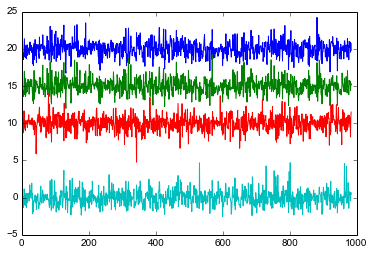

In [55]:
print ngram
plt.plot(eng1000['you']+20);
plt.plot(eng1000['will']+15);
plt.plot(eng1000['load']+10);
try:plt.plot(eng1000['precomputed']+5)
except:pass
plt.plot(id_corp[0,:]);

### Step 3. load model and predict response for each of the n-grams
 

In [ ]:
n_timepts = 300
n_vox = 60000
responses = np.random.randn(n_timepts, n_vox)

for response in responses:
    

### Step 4. load brain data and compute similarity to each of the n-grams

### step 5. construct output